# PyBATS

> PyBATS is a package for Bayesian time series modeling and forecasting. It is designed to enable both quick analyses and flexible options to customize the model form, prior, and forecast period. The core of the package is the class Dynamic Generalized Linear Model (`dglm`). The supported DGLMs are Poisson, Bernoulli, Normal (a DLM), and Binomial. These models are primarily based on [Bayesian Forecasting and Dynamic Models](http://www2.stat.duke.edu/~mw/West&HarrisonBook/).

## Install

PyBATS is hosted on _PyPI_ and can be installed with pip:

    $ pip install pybats

The most recent development version is hosted on [GitHub](https://github.com/lavinei/pybats). You can download and install from there:

```
$ git clone git@github.com:lavinei/pybats.git pybats
$ cd pybats
$ sudo python setup.py install
```

## Quick Start

This is the most basic example of Bayesian time series analysis using PyBATS. We'll use a public dataset of the sales of a dietary weight control product, along with the advertising spend. First we load in the data, and take a quick look at the first couples of entries:

In [ ]:
import numpy as np
import pandas as pd

from pybats_nbdev.shared import load_sales_example
from pybats_nbdev.analysis import *
from pybats_nbdev.point_forecast import *
from pybats_nbdev.plot import *

# Load example sales and advertising data. Source: Abraham & Ledolter (1983)
data = load_sales_example()             
data.head(3)

,Sales,Advertising
1,15,12.0
2,16,20.5
3,18,21.0


The sales are integer valued counts, which we model with a Poisson Dynamic Generalized Linear Model (DGLM). Second, we extract the outcome (_Y_) and covariates (_X_) from this dataset. We'll set the forecast horizon _k=1_ for this example. We could look at multiple forecast horizons by setting k to a larger value. `analysis`, a core PyBATS function, will automatically:
- Define the model (a Poisson DGLM)
- Sequentially update the model coefficients with each new observation $y_t$ (also known as forward filtering)
- Forecast $k=1$ step ahead at each desired time point

The main parameters that we need to specify are the dates during which the model will forecast. In this case we specify the start and end date with integers, because there are no actual dates associated with this dataset.

In [ ]:
Y = data['Sales'].values
X = data['Advertising'].values.reshape(-1,1)

k = 1                                               # Forecast 1 step ahead
forecast_start = 15                                 # Start forecast at time step 15
forecast_end = 35                                   # End forecast at time step 35 (final time step)

By default, `analysis` will return samples from the forecast distribution as well as the model after the final observation.

In [ ]:
mod, samples = analysis(Y, X, family="poisson",
forecast_start=forecast_start,      # First time step to forecast on
forecast_end=forecast_end,          # Final time step to forecast on
k=k,                                # Forecast horizon. If k>1, default is to forecast 1:k steps ahead, marginally
prior_length=6,                     # How many data point to use in defining prior
rho=.5,                             # Random effect extension, which increases the forecast variance (see Berry and West, 2019)
deltrend=0.95,                      # Discount factor on the trend component (the intercept)
delregn=0.95                        # Discount factor on the regression component
)

beginning forecasting


The model has the posterior mean and variance of the coefficients (also known as the state vector) stored as `mod.a` and `mod.C` respectively. We can view them in a nicer format with the method `mod.get_coef`.

In [ ]:
mod.get_coef()

,Mean,Standard Deviation
Intercept,0.63,0.36
Regn 1,0.08,0.01


Finally, we turn our attention to the forecasts. At each time step within the forecast window, $15 \leq t \leq 35$, the model drew samples from the forecast distribution $k=1$ steps into the future. We will plot the sales, median forecast, and $95\%$ credible interval using these samples.

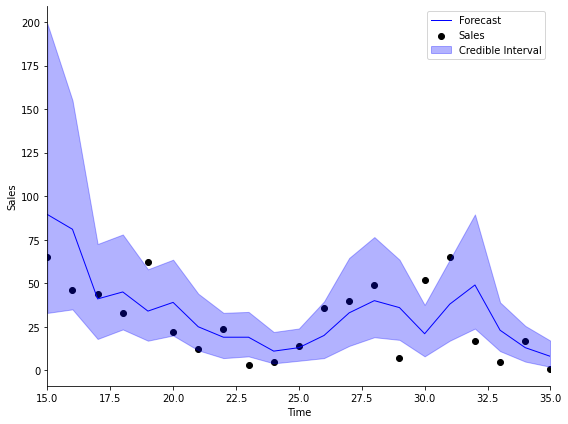

In [ ]:
import matplotlib.pyplot as plt

# Take the median as the point forecast
forecast = median(samples)                                  

# Plot the 1-step ahead point forecast plus the 95% credible interval
fig, ax = plt.subplots(1,1, figsize=(8, 6))   
ax = plot_data_forecast(fig, ax, Y[forecast_start:forecast_end + k], forecast, samples,
                        dates=np.arange(forecast_start, forecast_end+1, dtype='int'))
ax = ax_style(ax, ylabel='Sales', xlabel='Time', xlim=[forecast_start, forecast_end],
              legend=['Forecast', 'Sales', 'Credible Interval'])

## Types of Models

All models in PyBATS are based on DGLMs, which are well described by their name:

1. **Dynamic**: The coefficients are changing over *time*
2. **Generalized**: We can choose the distribution of the observations (Normal, Poisson, Bernoulli, or Binomial)
3. **Linear**: Forecasts are made by a standard linear combination of coefficients multiplied by predictors

The correct model type depends upon your time series, $y_t$. The most common type of observations are continuous real numbers, which can often be modeled using a normal Dynamic Linear Model (`dlm`).

PyBATS is unique in the current Python ecosystem because it provides dynamic models for non-normally distribution observations:

- Poisson DGLMs (`pois_dglm`) model positive integers, as in the example above with counts of daily item sales.
- Bernoulli DGLMs (`bern_dglm`) model data that can be encoded as $0-1$, or success-failure. An example is a time series of changes in stock price, where positive changes are coded as $1$, and negative changes are coded as $0$.
- Binomial DGLMs (`bin_dglm`) model the sum of Bernoulli $0-1$ outcomes. An example is the daily count of responses to a survey, in which $n_t$ people are contacted each day, and $y_t$ people choose to respond.

## Model Components

The *linear* combination in a DGLM is the multiplication (dot product) of the state vector by the regression vector 

$$\lambda_t = F_t^{'} \theta_t$$

Where:
- $\lambda_t$ is called the linear predictor
- $\theta_t$ is called the state vector
- $F_t$ is called the regression vector


The coefficients in a DGLM are all stored in the state vector, $\theta_t$. The state vector is defined by a set of different *components*, which are defined up front by the modeler. 

### Trend Component

PyBATS supports $0$, $1$, and $2$ trend coefficients in a DGLM. $1$ trend term is simply an intercept in the model. If there are $2$ trend terms, then the model contains an intercept *and* a local slope, which is the rate that the intercept changes over time. Because all coefficients are dynamic, both the intercept and local slope will change over time.

The default setting is to have only an intercept term, which we can see from the model defined in the example above:

In [ ]:
mod.ntrend

1

We can access the mean $E\left[ \theta_t \right]$ and variance $V\left[ \theta_t \right]$ of the state vector by the attribute names **a** and **R**. We use the trend indices, given by `mod.itrend`, to view the trend component of the state vector.

In [ ]:
mod.a[mod.itrend].round(2), mod.R.diagonal()[mod.itrend].round(2)

(array([[0.63]]), array([0.13]))

We can also access this information using `get_coef`, while specifying the component we want. Note that `get_coef` provides the coefficient standard deviations, rather than the variances.

In [ ]:
mod.get_coef('trend')

,Mean,Standard Deviation
Intercept,0.63,0.36


This means that the intercept term has a mean of $0.63$ and a standard deviation of $0.36$ at time T, the end of the analysis. The analysis is over either at time `forecast_end`, or when we hit the final observation in `Y`, whichever comes first.

To add in a local slope, we can re-run the analysis from above while specifying that `ntrend=2`.

In [ ]:
mod, samples = analysis(Y, X, family="poisson",
ntrend=2,                           # Use an intercept and local slope
forecast_start=forecast_start,      # First time step to forecast on
forecast_end=forecast_end,          # Final time step to forecast on
k=k,                                # Forecast horizon. If k>1, default is to forecast 1:k steps ahead, marginally
prior_length=6,                     # How many data point to use in defining prior
rho=.5,                             # Random effect extension, increases variance of Poisson DGLM (see Berry and West, 2019)
deltrend=0.95,                      # Discount factor on the trend component (intercept)
delregn=0.95                        # Discount factor on the regression component
)

beginning forecasting


In [ ]:
mod.ntrend

2

We can plot the forecasts with this new model, and see that the results are quite similar!

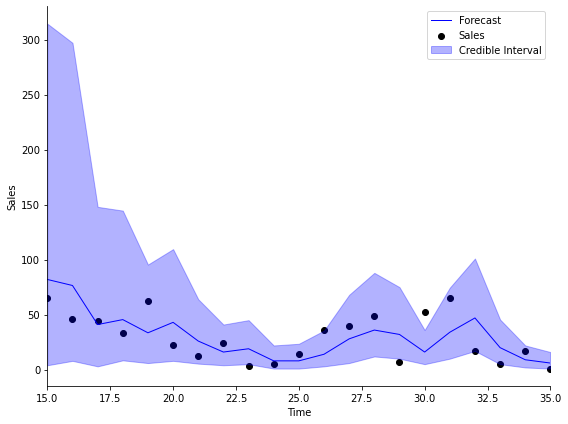

In [ ]:
# Take the median as the point forecast
forecast = median(samples)                                  

# Plot the 1-step ahead point forecast plus the 95% credible interval
fig, ax = plt.subplots(1,1, figsize=(8, 6))   
ax = plot_data_forecast(fig, ax, Y[forecast_start:forecast_end + k], forecast, samples,
                        dates=np.arange(forecast_start, forecast_end+1, dtype='int'))
ax = ax_style(ax, ylabel='Sales', xlabel='Time', xlim=[forecast_start, forecast_end],
              legend=['Forecast', 'Sales', 'Credible Interval'])

### Regression Component

The regression component contains all known predictors. In this example, the advertising budget is our only predictor, which is stored in the $X$ array. When there are multiple predictors, each column of $X$ is a separate predictor. We can look at the first 5 elements of $X$:

In [ ]:
X[:5]

array([[12. ],
       [20.5],
       [21. ],
       [15.5],
       [15.3]])

The `analysis` function automatically detected that $X$ only had $1$ column, and so it defined the model to have the correct number of regression components.

In [ ]:
mod.nregn

1

To understand the impact of advertising on sales, we can look at the regression coefficients at the final time step. Similar to the trend component, the indices for the regression component are stored in `mod.iregn`.

In [ ]:
mod.a[mod.iregn].round(4), mod.R.diagonal()[mod.iregn].round(4)

(array([[0.0954]]), array([0.0005]))

And just as before, we can also view this information using `get_coef`, with `component='regn'`.

In [ ]:
mod.get_coef('regn')

,Mean,Standard Deviation
Regn 1,0.1,0.02


The coefficient mean is $0.01$, with a very small standard deviation. Because the mean of the coefficient is positive, we interpret this coefficient as saying that an increase in advertising will increase our forecast of sales. Good, that makes sense! To precisely interpret the size of the effect, you need to know the link function for a Poisson DGLM, provided at `pois_dglm`, in the `dglm` module.

To quantify the uncertainty of the parameter, many people like to use the standard deviation (or standard error) of the coefficient, which is simply the square root of the variance. A good rule of thumb to get a pseudo-confidence interval is to add $\pm$ 2*sd(coefficient).

In [ ]:
mean, sd = mod.get_coef('regn').values[0]
np.round(mean + 2 * sd, 2), np.round(mean - 2 * sd, 2)

(0.14, 0.06)

### Seasonal Component

Seasonal components represent cyclic or periodic behavior in the time series  - often daily, weekly, or annual patterns. In PyBATS, seasonal components are defined by their period (e.g. $p = 7$ for a weekly trend on daily observation), and their harmonic components. Each harmonic component involves a sine and a cosine function with $2$ parameters, so there should never be more than $p/2$ harmonic components, or the model is over-parameterized.

For example, if the period is $p=7$ (defined by setting `seasPeriods=[7]`) then a fully parameterized seasonal component has harmonic components `seasHarmComponents = [1,2,3]`.

If there is an annual trend on daily data, then the period is $p=365$. However, using all possible harmonic components, `seasHarmComponents = [1,2,...,182]`, is far too many parameters to learn. It is much more common to use the first several harmonic components, such as `seasHarmComponents = [1,2]`. The $r^{th}$ harmonic component has a cycle legth of $p/r$. So in the example of an annual pattern, the first harmonic component will have a cycle length of $365/2 = 182.5$, representing a semi-annual cycle, and the second harmonic component will have a length of $365/4$, for a quarterly cycle.

For more details, refer to Chapter 8.6 in [Bayesian Forecasting and Dynamic Models](http://www2.stat.duke.edu/~mw/West&HarrisonBook/) by West and Harrison.

To see this in action, we'll load in some simulated daily sales data:

In [ ]:
#hide
from pandas.tseries.holiday import USFederalHolidayCalendar

In [ ]:
from pybats_nbdev.shared import load_sales_example2
data = load_sales_example2()
data.head()

,Sales,Price,Promotion
Date,,,
2014-06-01,15.0,1.11,0.0
2014-06-02,13.0,2.19,0.0
2014-06-03,6.0,0.23,0.0
2014-06-04,2.0,-0.05,1.0
2014-06-05,6.0,-0.14,0.0


The simulated dataset contains daily sales of an item from June 1, 2014 to June 1, 2018. 

- The Price column represents percent change in price from the moving average, so it's centered at 0.
- Promotion is a 0-1 indicator for a specific sale or promotion on the item.

Before we run an analysis, we again need to specify a few arguments

In [ ]:
prior_length = 21   # Number of days of data used to set prior
k = 1               # Forecast horizon
rho = 0.5           # Random effect discount factor to increase variance of forecast distribution
forecast_samps = 1000  # Number of forecast samples to draw
forecast_start = pd.to_datetime('2018-01-01') # Date to start forecasting
forecast_end = pd.to_datetime('2018-06-01')   # Date to stop forecasting
Y = data['Sales'].values
X = data[['Price', 'Promotion']].values

And most importantly, we need to specify that the retail sales will have a seasonality component with a $7-$day period:

In [ ]:
seasPeriods=[7]
seasHarmComponents = [[1,2,3]]

In [ ]:
mod, samples = analysis(Y, X,
                        k, forecast_start, forecast_end, nsamps=forecast_samps,
                        family='poisson',
                        seasPeriods=seasPeriods, 
                        seasHarmComponents=seasHarmComponents,
                        prior_length=prior_length, 
                        dates=data.index,
                        rho=rho,
                        ret = ['model', 'forecast'])

beginning forecasting


We can visualize the forecasts, and instantly see the pattern in the forecasts coming from the weekly seasonality:

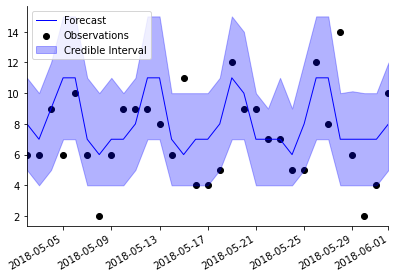

In [ ]:
plot_length = 30
data_1step = data.loc[forecast_end-pd.DateOffset(30):forecast_end]
samples_1step = samples[:,-31:,0]
fig, ax = plt.subplots(1,1)
ax = plot_data_forecast(fig, ax,
                        data_1step.Sales,
                        median(samples_1step),
                        samples_1step,
                        data_1step.index,
                        credible_interval=75)

### Holidays and Special Events

PyBATS provides a method to specify known holidays, special events, and other outliers in the data. `analysis` will automatically add in an indicator (dummy) variable to the regression component for each occurance of the holiday.

There are two reasons this can be useful. First, adding in a known and repeated special event can improve forecast accuracy. Second, the indicator variable will help protect the other coefficients in the model from overreacting to these outliers in the data.

To demonstrate, let's repeat the analysis of simulated retail sales from above, while including a holiday effect:

In [ ]:
holidays = USFederalHolidayCalendar.rules

mod, samples = analysis(Y, X,
                        k, forecast_start, forecast_end, nsamps=forecast_samps,
                        family='poisson',
                        seasPeriods=seasPeriods, seasHarmComponents=seasHarmComponents,
                        prior_length=prior_length, dates=data.index,
                        holidays=holidays,
                        rho=rho,
                        ret = ['model', 'forecast'])

beginning forecasting


We've just used the standard holidays in the US Federal Calendar, but you can specify your own list of holidays using the class [pandas.tseries.holiday](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#holidays-holiday-calendars).

In [ ]:
holidays

[Holiday: New Years Day (month=1, day=1, observance=<function nearest_workday at 0x7f8cec6d13b0>),
 Holiday: Martin Luther King Jr. Day (month=1, day=1, offset=<DateOffset: weekday=MO(+3)>),
 Holiday: Presidents Day (month=2, day=1, offset=<DateOffset: weekday=MO(+3)>),
 Holiday: Memorial Day (month=5, day=31, offset=<DateOffset: weekday=MO(-1)>),
 Holiday: July 4th (month=7, day=4, observance=<function nearest_workday at 0x7f8cec6d13b0>),
 Holiday: Labor Day (month=9, day=1, offset=<DateOffset: weekday=MO(+1)>),
 Holiday: Columbus Day (month=10, day=1, offset=<DateOffset: weekday=MO(+2)>),
 Holiday: Veterans Day (month=11, day=11, observance=<function nearest_workday at 0x7f8cec6d13b0>),
 Holiday: Thanksgiving (month=11, day=1, offset=<DateOffset: weekday=TH(+4)>),
 Holiday: Christmas (month=12, day=25, observance=<function nearest_workday at 0x7f8cec6d13b0>)]

Look again at the plot of forecasts above. A number of the observations fall outside of the $95\%$ credible intervals. One of those is on May 28, 2018 - Memorial Day. How does it look now?

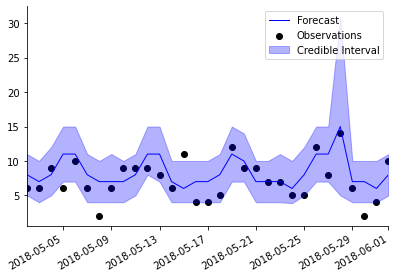

In [ ]:
plot_length = 30
data_1step = data.loc[forecast_end-pd.DateOffset(30):forecast_end]
samples_1step = samples[:,-31:,0]
fig, ax = plt.subplots(1,1)
ax = plot_data_forecast(fig, ax,
                        data_1step.Sales,
                        median(samples_1step),
                        samples_1step,
                        data_1step.index,
                        credible_interval=75)

The point forecast (dark blue line) is higher for Memorial Day, and the $95\%$ confidence interval (light blue shaded region) is much wider. The higher point forecast reflects what the model has learned from Memorial Day in previous years, and the presence of the Memorial Day coefficient also increases the forecast uncertainty.

## Discount Factors

Discount factors are model hyperparameters that have to be specified before an analysis begins. They control the rate at which coefficients are allowed to change, and have a very simple interpretation. For a discount factor $\delta=0.98$, then at each time step we *discount* the old coefficient information by adding $100\% - 98\% = 2\%$ more uncertainty (variance). This enables the coefficient to learn more quickly from new observations in the time series. If all discount factors are set to $\delta=1$ then there is no discounting, and the models become standard generalized linear models.

There is a trade-off to lowering the discount factors. While it allows the coefficients to change more over time, it will increase the uncertainty in the forecasts, and can make the coefficients too sensitive to noise in the data.

PyBATS has built-in safety measures that prevent the variance from growing too large. This makes the models significantly more robust to lower discount factors. Even so, most discount factors should be between $0.9$ and $1$. For rarely observed predictors - like holidays - it's typically best to leave the discount factor at $1$.

PyBATS allows discount factors to be set separately for each component, and even for each individual coefficient if desired.

In [ ]:
deltrend = 0.98 # Discount factor on the trend component
delregn = 0.98 # Discount factor on the regression component
delseas = 0.98 # Discount factor on the seasonal component
delhol = 1 # Discount factor on the holiday component
rho = .3 # Random effect discount factor to increase variance of forecast distribution

mod, samples = analysis(Y, X,
                        k, forecast_start, forecast_end, nsamps=forecast_samps,
                        family='poisson',
                        seasPeriods=seasPeriods, seasHarmComponents=seasHarmComponents,
                        prior_length=prior_length, dates=data.index,
                        holidays=holidays,
                        rho=rho,
                        deltrend = deltrend,
                        delregn=delregn,
                        delseas=delseas,
                        delhol=delhol,
                        ret = ['model', 'forecast'])

beginning forecasting


The default discount factors in PyBATS are fairly high, so in this example we've set them to $\delta=0.98$ for the trend, regression, and seasonal components. This will allow those coefficient to adapt more rapidly. The holiday component is left at $\delta=1$.

We also changed the parameter $\rho=0.3$. This is a special discount factor which increases the *forecast* uncertainty, rather than discounting information on a coefficient. The smaller $\rho$ is, the wider the forecast interval. It typically lies within $0 < \rho < 1$, because most dataset have more uncertainty than expected from a standard Poisson distribution. However, $\rho$ can go higher than $1$ if the goal is to shrink the forecast intervals.

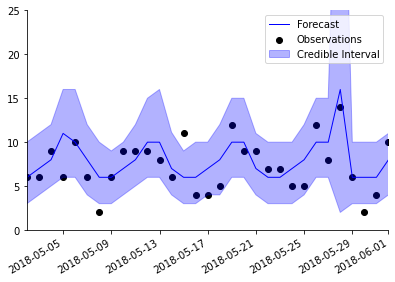

In [ ]:
plot_length = 30
data_1step = data.loc[forecast_end-pd.DateOffset(30):forecast_end]
samples_1step = samples[:,-31:,0]
fig, ax = plt.subplots(1,1)
ax = plot_data_forecast(fig, ax,
                        data_1step.Sales,
                        median(samples_1step),
                        samples_1step,
                        data_1step.index,
                        credible_interval=75)
ax.set_ylim([0, 25]);

## Combinations of DGLMs

PyBATS has built in more several combinations of DGLMs, which allow for more flexible forecast distributions.

The Dynamic Count Mixture Model (`dcmm`) is the combination of a Bernoulli and a Poisson DGLM, developed in [Berry and West (2019)](https://arxiv.org/pdf/1805.05232.pdf).

The Dynamic Binary Cascade Model (`dbcm`) is the combination of a DCMM and a binary cascade, developed in [Berry, Helman, and West (2020)](https://arxiv.org/pdf/1808.04698.pdf).



## Latent Factors

PyBATS also allows for the use of latent factors, which are random variables serving as regression predictors.

In the class `latent_factor`, the random predictors are described by a mean and a variance, developed in [Lavine, Cron, and West (2020)](https://arxiv.org/pdf/2007.04956.pdf).

They can also be integrated into a model through simulation, which is a more precise but slower process, as in [Berry and West (2019)](https://arxiv.org/pdf/1805.05232.pdf). The necessary functions are found on the `latent_factor_fxns` page.

## Examples

### [In-Depth Sales Forecasting Example](https://github.com/lavinei/pybats_nbdev/blob/master/examples/Poisson_DGLM_In_Depth_Example.ipynb)

This example continues the analysis of retail sales, and dives into interpretation of model coefficients, especially the weekly seasonal effects. It also demonstrates how to use the PyBATS plotting functions to effectively visualize your forecasts.

### [DCMM Example with Latent Factors](https://github.com/lavinei/pybats_nbdev/blob/master/examples/DCMM%20Latent%20Factor%20Example.ipynb)

This example demonstrates how to use a `dcmm` for modeling retail sales. A latent factor is derived from aggregate sales, and used to enhance forecasts for an individual item.

### [DBCM Example with Latent Factors](https://github.com/lavinei/pybats_nbdev/blob/master/examples/DBCM%20Latent%20Factor%20Example.ipynb)

This example demonstrates how to use a `dbcm` for modeling retail sales. A latent factor is derived from aggregate sales, and used to enhance forecasts for an individual item.